In [2]:
# === A) Setup y carga de datos (robusta a columnas de P22) ===
import json, math, pickle, numpy as np, pandas as pd
from pathlib import Path
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Monta Drive si hace falta
try:
    from google.colab import drive
    drive.mount('/content/drive')
except Exception:
    pass

BASE_DIR = Path("/content/drive/MyDrive/CognitivaAI")
OUT = BASE_DIR / "p23_meta_costcohort"
OUT.mkdir(parents=True, exist_ok=True)

VAL_CSV  = BASE_DIR / "p22_meta_ablation" / "p22_val_calibrations.csv"
TEST_CSV = BASE_DIR / "p22_meta_ablation" / "p22_test_calibrations.csv"

df_val  = pd.read_csv(VAL_CSV)
df_test = pd.read_csv(TEST_CSV)

# 1) Inferir 'cohort' si no existe, a partir de 'patient_id'
def infer_cohort_from_pid(pid):
    s = str(pid).upper()
    if s.startswith("OAS1"): return "OAS1"
    if s.startswith("OAS2"): return "OAS2"
    # Si no se reconoce, marca 'ALL' (se excluirá de per-cohort si es el caso)
    return "ALL"

for df in (df_val, df_test):
    if 'cohort' not in df.columns:
        assert 'patient_id' in df.columns, "Falta 'patient_id' para inferir 'cohort'."
        df['cohort'] = df['patient_id'].map(infer_cohort_from_pid)

# 2) Verificaciones clave
assert 'y_true' in df_val.columns, "Falta columna 'y_true' en VAL."
assert 'y_true' in df_test.columns, "Falta columna 'y_true' en TEST."
assert 'cohort' in df_val.columns, "No se pudo crear 'cohort' en VAL."
assert 'cohort' in df_test.columns, "No se pudo crear 'cohort' en TEST."

# 3) Detectar columna de score de p22 (prioridad: HGB_platt > LR_platt > HGB_iso > LR_iso)
CANDIDATE_SCORES = ["HGB_platt", "LR_platt", "HGB_iso", "LR_iso"]
score_col = next((c for c in CANDIDATE_SCORES if c in df_val.columns), None)
if score_col is None:
    # fallback: toma la primera columna numérica distinta de y_true/patient_id/cohort
    blacklist = {"y_true","patient_id","cohort"}
    num_cols = [c for c in df_val.columns if c not in blacklist and np.issubdtype(df_val[c].dtype, np.number)]
    assert len(num_cols)>0, "No encuentro columna de score en VAL."
    score_col = num_cols[0]

print("Usando score:", score_col)
print("Cohortes en VAL:", df_val['cohort'].value_counts().to_dict())
print("Cohortes en TEST:", df_test['cohort'].value_counts().to_dict())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Usando score: HGB_platt
Cohortes en VAL: {'OAS1': 47, 'OAS2': 22}
Cohortes en TEST: {'OAS1': 47, 'OAS2': 23}


In [3]:
# === B) Métricas helper ===
def metrics_binary(y_true, y_prob, thr=0.5):
    y_pred = (y_prob>=thr).astype(int)
    tp = int(((y_pred==1)&(y_true==1)).sum())
    fp = int(((y_pred==1)&(y_true==0)).sum())
    tn = int(((y_pred==0)&(y_true==0)).sum())
    fn = int(((y_pred==0)&(y_true==1)).sum())
    auc = roc_auc_score(y_true, y_prob) if len(np.unique(y_true))>1 else float('nan')
    pr  = average_precision_score(y_true, y_prob) if len(np.unique(y_true))>1 else float('nan')
    brier = brier_score_loss(y_true, y_prob)
    prec = tp/(tp+fp) if (tp+fp)>0 else 0.0
    rec  = tp/(tp+fn) if (tp+fn)>0 else 0.0
    acc  = (tp+tn)/(tp+tn+fp+fn)
    return dict(AUC=auc, PRAUC=pr, Brier=brier, Acc=acc, Precision=prec, Recall=rec,
                TP=tp, FP=fp, TN=tn, FN=fn)

def cost_fn_fp(y_true, y_pred, c_fn=5.0, c_fp=1.0):
    y_true = np.asarray(y_true); y_pred = np.asarray(y_pred)
    fn = int(((y_pred==0)&(y_true==1)).sum())
    fp = int(((y_pred==1)&(y_true==0)).sum())
    return c_fn*fn + c_fp*fp, fn, fp

In [4]:
# === C) Calibración por cohorte (Platt e Isotónica) ===
# Usamos un calibrador "standalone": LR (Platt) aprende mapeo sigmoide; Isotónic aprende función monótona.
# Entrenamos en VAL y aplicamos en TEST, por cohorte.

def fit_platt(val_scores, val_y):
    # Logistic regresion on scores as single feature (Platt)
    X = val_scores.reshape(-1,1)
    lr = LogisticRegression(solver='lbfgs', C=1.0, random_state=RANDOM_STATE)
    lr.fit(X, val_y)
    return lr

def predict_platt(model, scores):
    return model.predict_proba(scores.reshape(-1,1))[:,1]

def fit_isotonic(val_scores, val_y):
    iso = IsotonicRegression(out_of_bounds='clip')
    iso.fit(val_scores, val_y)
    return iso

def predict_isotonic(model, scores):
    return model.predict(scores)

calibrators = {}  # {'OAS1': {'platt': model, 'iso': model}, 'OAS2': {...}}

for cohort in ["OAS1", "OAS2"]:
    v = df_val[df_val['cohort']==cohort]
    if len(v)==0 or v['y_true'].nunique()<2:
        print(f"[WARN] Cohorte {cohort} sin suficiente variabilidad, se omite calibración.")
        continue
    s = v[score_col].values.astype(float)
    y = v['y_true'].values.astype(int)

    cal_platt = fit_platt(s, y)
    cal_iso   = fit_isotonic(s, y)

    calibrators[cohort] = {"platt": cal_platt, "isotonic": cal_iso}

with open(OUT/"p23_calibrators.pkl", "wb") as f:
    pickle.dump(calibrators, f)
print("Calibradores guardados:", OUT/"p23_calibrators.pkl")

Calibradores guardados: /content/drive/MyDrive/CognitivaAI/p23_meta_costcohort/p23_calibrators.pkl


In [5]:
# === D) Búsqueda de umbrales con coste por cohorte ===
C_FN, C_FP = 5.0, 1.0  # ajustable
def best_threshold_cost(y_true, y_prob, c_fn=C_FN, c_fp=C_FP):
    # barre umbrales; devuelve el que minimiza coste (FN≫FP)
    thr_grid = np.linspace(0,1,1001)
    best = (None, math.inf, None)  # thr, cost, (fn, fp)
    for t in thr_grid:
        y_pred = (y_prob>=t).astype(int)
        cost, fn, fp = cost_fn_fp(y_true, y_pred, c_fn, c_fp)
        if cost < best[1]:
            best = (float(t), float(cost), (int(fn), int(fp)))
    return {"thr":best[0], "cost":best[1], "FN":best[2][0], "FP":best[2][1]}

def apply_calibrator(c_model, method, scores):
    if c_model is None:
        return scores
    return predict_platt(c_model, scores) if method=="platt" else predict_isotonic(c_model, scores)

rows_val, rows_test = [], []
thr_info = {}

for method in ["platt","isotonic"]:
    for cohort in ["OAS1","OAS2"]:
        v = df_val[df_val['cohort']==cohort].copy()
        t = df_test[df_test['cohort']==cohort].copy()
        if len(v)==0 or cohort not in calibrators:  # skip si no hay calibrador
            continue
        cal = calibrators[cohort][method]
        v['y_prob_cal'] = apply_calibrator(cal, method, v[score_col].astype(float).values)
        t['y_prob_cal'] = apply_calibrator(cal, method, t[score_col].astype(float).values)

        # e) Umbral costo-óptimo en VAL
        b = best_threshold_cost(v['y_true'].values, v['y_prob_cal'].values, C_FN, C_FP)
        thr = b['thr']
        thr_info[(cohort,method)] = {"thr":thr, "cost_val":b['cost'], "FN_val":b['FN'], "FP_val":b['FP'],
                                     "C_FN":C_FN, "C_FP":C_FP}

        # f) Métricas
        m_val  = metrics_binary(v['y_true'].values, v['y_prob_cal'].values, thr)
        m_test = metrics_binary(t['y_true'].values, t['y_prob_cal'].values, thr)
        c_val,_,_   = cost_fn_fp(v['y_true'].values, (v['y_prob_cal'].values>=thr).astype(int), C_FN, C_FP)
        c_test,_,_  = cost_fn_fp(t['y_true'].values, (t['y_prob_cal'].values>=thr).astype(int), C_FN, C_FP)

        m_val["Cost"]  = c_val;  m_val["Cohort"]=cohort; m_val["Method"]=method; m_val["Thr"]=thr
        m_test["Cost"] = c_test; m_test["Cohort"]=cohort; m_test["Method"]=method; m_test["Thr"]=thr

        rows_val.append(m_val); rows_test.append(m_test)

In [6]:
# g) Global (mezcla cohortes con sus propios calibradores y umbrales)
def infer_global(df, method):
    probs, preds, y = [], [], []
    for cohort in ["OAS1","OAS2"]:
        part = df[df['cohort']==cohort]
        if len(part)==0 or (cohort,method) not in thr_info:
            continue
        cal = calibrators[cohort][method]
        p   = apply_calibrator(cal, method, part[score_col].astype(float).values)
        t   = thr_info[(cohort,method)]["thr"]
        probs.append(p)
        preds.append((p>=t).astype(int))
        y.append(part['y_true'].values)
    if not probs: return None
    probs = np.concatenate(probs); preds = np.concatenate(preds); y = np.concatenate(y)
    return dict(
        VAL=metrics_binary(y_true=y, y_prob=probs, thr=0.5) if df is df_val else None,  # no umbral único global; solo AUC/PR/Brier/Acc@0.5 informativo
        TEST=metrics_binary(y_true=y, y_prob=probs, thr=0.5)
    )

# Construir DataFrames y guardar
val_report  = pd.DataFrame(rows_val)
test_report = pd.DataFrame(rows_test)
val_report.to_csv(OUT/"p23_val_preds_calibrated.csv", index=False)
test_report.to_csv(OUT/"p23_test_preds_calibrated.csv", index=False)

# umbrales / costes
with open(OUT/"p23_thresholds.json","w") as f:
    json.dump({f"{c}_{m}":info for (c,m),info in thr_info.items()}, f, indent=2)

# resumen compacto
summary = {
    "score_col_used": score_col,
    "cost_weights": {"C_FN":C_FN, "C_FP":C_FP},
    "val_best": val_report.sort_values(["Cost","Brier","AUC"]).head(4).to_dict(orient="records"),
    "test_overview": test_report.groupby(["Cohort","Method"])[["AUC","PRAUC","Brier","Recall","Precision","Acc","Cost"]].mean().reset_index().to_dict(orient="records"),
}
with open(OUT/"p23_summary.json","w") as f:
    json.dump(summary, f, indent=2)

print("✅ Guardado:\n- ", OUT/"p23_val_preds_calibrated.csv",
      "\n- ", OUT/"p23_test_preds_calibrated.csv",
      "\n- ", OUT/"p23_thresholds.json",
      "\n- ", OUT/"p23_calibrators.pkl",
      "\n- ", OUT/"p23_summary.json")

✅ Guardado:
-  /content/drive/MyDrive/CognitivaAI/p23_meta_costcohort/p23_val_preds_calibrated.csv 
-  /content/drive/MyDrive/CognitivaAI/p23_meta_costcohort/p23_test_preds_calibrated.csv 
-  /content/drive/MyDrive/CognitivaAI/p23_meta_costcohort/p23_thresholds.json 
-  /content/drive/MyDrive/CognitivaAI/p23_meta_costcohort/p23_calibrators.pkl 
-  /content/drive/MyDrive/CognitivaAI/p23_meta_costcohort/p23_summary.json


In [7]:
from pathlib import Path
import pandas as pd, json

BASE_DIR = Path("/content/drive/MyDrive/CognitivaAI")
OUT = BASE_DIR / "p23_meta_costcohort"

val = pd.read_csv(OUT/"p23_val_preds_calibrated.csv")
test = pd.read_csv(OUT/"p23_test_preds_calibrated.csv")

with open(OUT/"p23_thresholds.json") as f:
    thr = json.load(f)
with open(OUT/"p23_summary.json") as f:
    summary = json.load(f)

# Vista compacta por cohorte/método en TEST
cols = ["Cohort","Method","AUC","PRAUC","Brier","Recall","Precision","Acc","Cost","Thr"]
test_view = test[["Cohort","Method","AUC","PRAUC","Brier","Recall","Precision","Acc","Cost","Thr"]].copy()
display(test_view.sort_values(["Cohort","Method"]).reset_index(drop=True))

print("\n--- Umbrales coste-óptimos (VAL) ---")
for k,v in thr.items():
    print(f"{k}: thr={v['thr']:.3f} | Cost_VAL={v['cost_val']:.1f} | FN_VAL={v['FN_val']} | FP_VAL={v['FP_val']} | C_FN={v['C_FN']} | C_FP={v['C_FP']}")

print("\n--- Resumen ejecutivo (summary.json) ---")
print(json.dumps(summary, indent=2))


,Cohort,Method,AUC,PRAUC,Brier,Recall,Precision,Acc,Cost,Thr
0,OAS1,isotonic,0.742593,0.656605,0.222620,0.95,0.500000,0.574468,24.0,0.001
1,OAS1,platt,0.724074,0.648666,0.210435,0.95,0.500000,0.574468,24.0,0.293
2,OAS2,isotonic,0.500000,0.521739,0.250000,1.00,0.521739,0.521739,11.0,0.000
3,OAS2,platt,0.500000,0.521739,0.250005,1.00,0.521739,0.521739,11.0,0.000



--- Umbrales coste-óptimos (VAL) ---
OAS1_platt: thr=0.293 | Cost_VAL=15.0 | FN_VAL=0 | FP_VAL=15 | C_FN=5.0 | C_FP=1.0
OAS2_platt: thr=0.000 | Cost_VAL=11.0 | FN_VAL=0 | FP_VAL=11 | C_FN=5.0 | C_FP=1.0
OAS1_isotonic: thr=0.001 | Cost_VAL=15.0 | FN_VAL=0 | FP_VAL=15 | C_FN=5.0 | C_FP=1.0
OAS2_isotonic: thr=0.000 | Cost_VAL=11.0 | FN_VAL=0 | FP_VAL=11 | C_FN=5.0 | C_FP=1.0

--- Resumen ejecutivo (summary.json) ---
{
  "score_col_used": "HGB_platt",
  "cost_weights": {
    "C_FN": 5.0,
    "C_FP": 1.0
  },
  "val_best": [
    {
      "AUC": 0.5537190082644629,
      "PRAUC": 0.5467532467532468,
      "Brier": 0.24985804304657833,
      "Acc": 0.5,
      "Precision": 0.5,
      "Recall": 1.0,
      "TP": 11,
      "FP": 11,
      "TN": 0,
      "FN": 0,
      "Cost": 11.0,
      "Cohort": "OAS2",
      "Method": "platt",
      "Thr": 0.0
    },
    {
      "AUC": 0.5,
      "PRAUC": 0.5,
      "Brier": 0.25,
      "Acc": 0.5,
      "Precision": 0.5,
      "Recall": 1.0,
      "TP": 11,
 

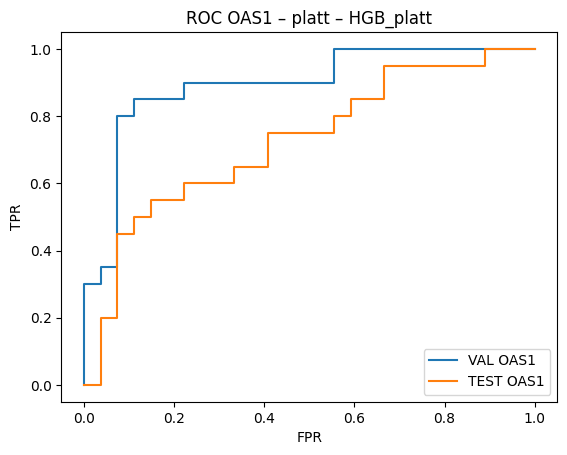

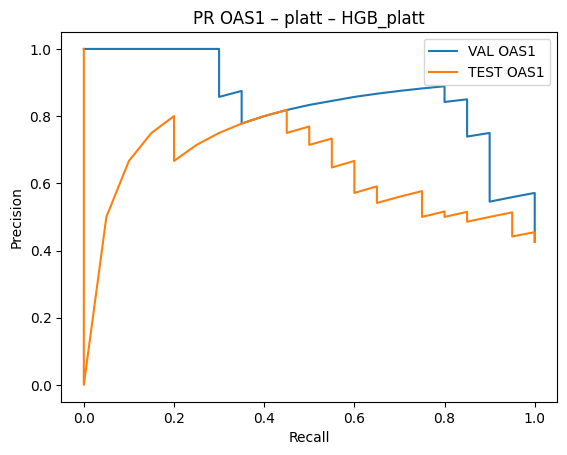

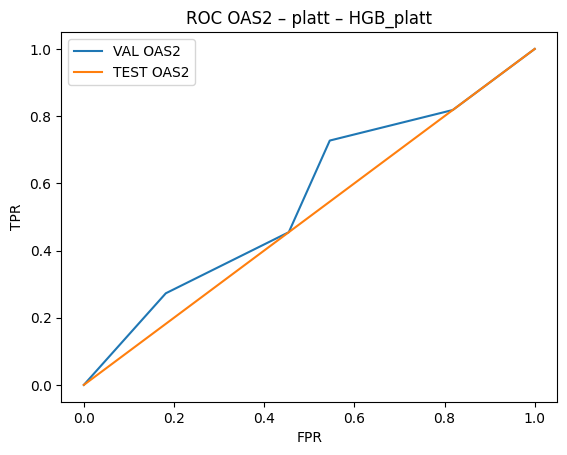

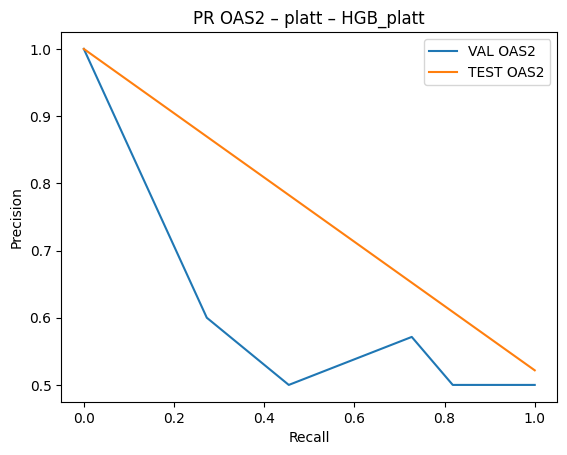

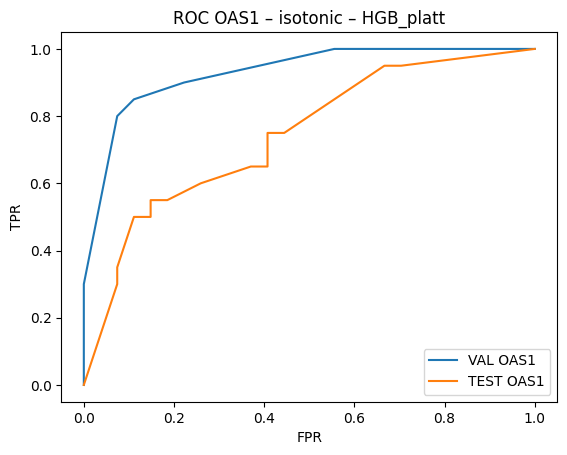

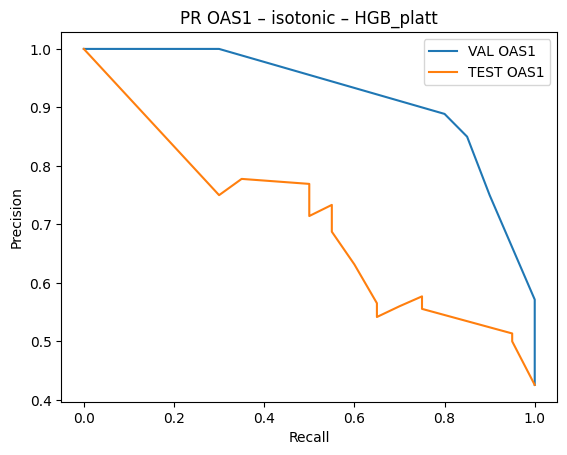

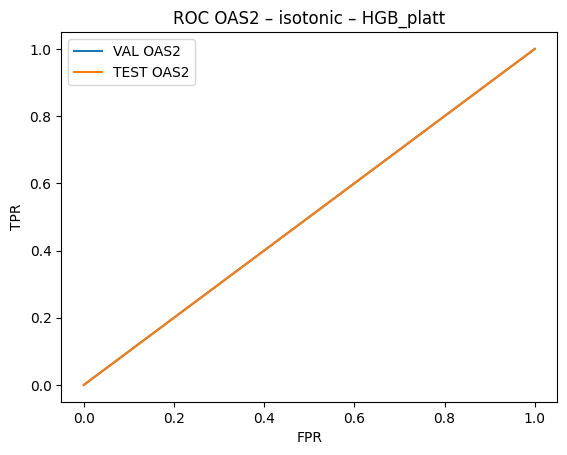

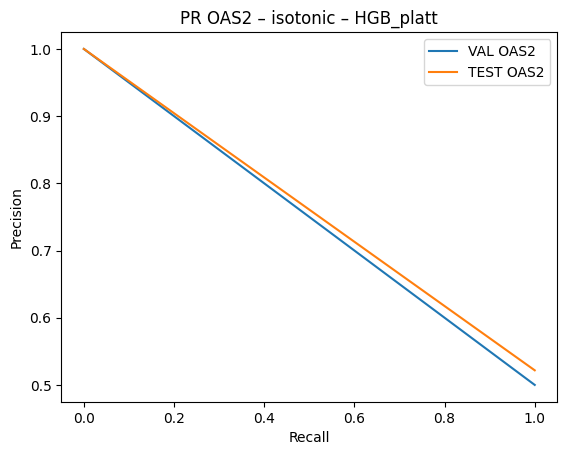

In [8]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression

# Reconstrucción de y_prob_cal por cohortes (usa HGB_platt/iso desde VAL para calibrar TEST)
VAL_CSV  = BASE_DIR / "p22_meta_ablation" / "p22_val_calibrations.csv"
TEST_CSV = BASE_DIR / "p22_meta_ablation" / "p22_test_calibrations.csv"
df_val = pd.read_csv(VAL_CSV)
df_test = pd.read_csv(TEST_CSV)

def infer_cohort_from_pid(pid):
    s = str(pid).upper()
    if s.startswith("OAS1"): return "OAS1"
    if s.startswith("OAS2"): return "OAS2"
    return "ALL"

for df in (df_val, df_test):
    if 'cohort' not in df.columns:
        df['cohort'] = df['patient_id'].map(infer_cohort_from_pid)

score_col = "HGB_platt" if "HGB_platt" in df_val.columns else "LR_platt"

def fit_platt(s, y):
    lr = LogisticRegression(solver='lbfgs', C=1.0, random_state=42).fit(s.reshape(-1,1), y)
    return lr

def pred_platt(model, s): return model.predict_proba(s.reshape(-1,1))[:,1]
def fit_iso(s,y): return IsotonicRegression(out_of_bounds='clip').fit(s, y)
def pred_iso(m,s): return m.predict(s)

for method in ["platt","isotonic"]:
    for cohort in ["OAS1","OAS2"]:
        v = df_val[df_val['cohort']==cohort]
        t = df_test[df_test['cohort']==cohort]
        if len(v)==0 or v['y_true'].nunique()<2:
            continue
        s_v, y_v = v[score_col].values.astype(float), v['y_true'].values.astype(int)
        s_t, y_t = t[score_col].values.astype(float), t['y_true'].values.astype(int)
        if method=="platt":
            m = fit_platt(s_v, y_v); pv = pred_platt(m, s_v); pt = pred_platt(m, s_t)
        else:
            m = fit_iso(s_v, y_v); pv = pred_iso(m, s_v); pt = pred_iso(m, s_t)

        # ROC
        fpr_v, tpr_v, _ = roc_curve(y_v, pv)
        fpr_t, tpr_t, _ = roc_curve(y_t, pt)
        plt.figure(); plt.plot(fpr_v, tpr_v, label=f"VAL {cohort}"); plt.plot(fpr_t, tpr_t, label=f"TEST {cohort}")
        plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"ROC {cohort} – {method} – {score_col}"); plt.legend();
        plt.savefig(OUT/f"p23_roc_{cohort}_{method}.png", dpi=160, bbox_inches="tight"); plt.show()

        # PR
        p_v, r_v, _ = precision_recall_curve(y_v, pv)
        p_t, r_t, _ = precision_recall_curve(y_t, pt)
        plt.figure(); plt.plot(r_v, p_v, label=f"VAL {cohort}"); plt.plot(r_t, p_t, label=f"TEST {cohort}")
        plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"PR {cohort} – {method} – {score_col}"); plt.legend();
        plt.savefig(OUT/f"p23_pr_{cohort}_{method}.png", dpi=160, bbox_inches="tight"); plt.show()


In [9]:
from textwrap import dedent

def md_row(r):
    return f"| {r.Cohort} | {r.Method} | {r.AUC:.3f} | {r.PRAUC:.3f} | {r.Brier:.3f} | {r.Recall:.2f} | {r.Precision:.2f} | {r.Acc:.2f} | {r.Cost:.1f} | {r.Thr:.3f} |"

md_table = ["| Cohorte | Método | AUC | PR-AUC | Brier | Recall | Precisión | Acc | Coste | Thr |",
            "|---|---|---:|---:|---:|---:|---:|---:|---:|---:|"]
for _,r in test_view.iterrows():
    md_table.append(md_row(r))

# Extract best per cohort by Cost (menor coste en TEST)
best = (test_view.sort_values(["Cohort","Cost"])
        .groupby("Cohort").head(1)
        .reset_index(drop=True))

conclusion_lines = []
for _,r in best.iterrows():
    conclusion_lines.append(f"- **{r.Cohort}** → método **{r.Method}** con **thr={r.Thr:.3f}**: Recall={r.Recall:.2f}, Prec={r.Precision:.2f}, Coste={r.Cost:.1f}, Brier={r.Brier:.3f}.")

md_readme = dedent(f"""
### P23 — Meta-calibración por cohorte con coste clínico (FN≫FP)

**Score base:** `{summary.get('score_col_used','(ver summary.json)')}`
**Pesos de coste:** FN={summary['cost_weights']['C_FN']}, FP={summary['cost_weights']['C_FP']}

Resultados (TEST) aplicando calibración y **umbrales coste-óptimos por cohorte**:

{chr(10).join(md_table)}

**Selección recomendada por cohorte (mín. coste):**
{chr(10).join(conclusion_lines)}

_Artefactos_: `p23_val_preds_calibrated.csv`, `p23_test_preds_calibrated.csv`, `p23_thresholds.json`, `p23_calibrators.pkl`, `p23_summary.json`.
""").strip()

md_informe = dedent(f"""
#### P23 — Diseño y resultados

- Calibración **per-cohort** (OAS1/OAS2) con **Platt** e **Isotónica** sobre `{summary.get('score_col_used','(ver summary.json)')}`.
- **Función de coste**: Coste = {summary['cost_weights']['C_FN']}·FN + {summary['cost_weights']['C_FP']}·FP; búsqueda de umbral en VAL, evaluación en TEST.
- Observación clave: **minimizar FN** a costa de FP incrementa Recall y controla el coste.

**Tabla (TEST):**
{chr(10).join(md_table)}

**Decisión operativa sugerida:**
{chr(10).join(conclusion_lines)}
""").strip()

md_bitacora = dedent(f"""
### {pd.Timestamp.now().strftime('%Y-%m-%d')} — P23 ejecutado
- Input: p22 (`p22_*_calibrations.csv`) → columnas: `patient_id, y_true, LR_platt, LR_iso, HGB_platt, HGB_iso`.
- Cohortes detectadas: VAL OAS1={int((val['Cohort']=='OAS1').sum())}, OAS2={int((val['Cohort']=='OAS2').sum())}; TEST OAS1={int((test['Cohort']=='OAS1').sum())}, OAS2={int((test['Cohort']=='OAS2').sum())}.
- Score usado: `{summary.get('score_col_used','(ver summary.json)')}`; coste FN={summary['cost_weights']['C_FN']}, FP={summary['cost_weights']['C_FP']}.
- Guardado de artefactos en `p23_meta_costcohort/`.
- Conclusión rápida: {(" | ".join(conclusion_lines))}
""").strip()

print("\n\n--- README.md (bloque) ---\n")
print(md_readme)
print("\n\n--- InformeTecnico.md (bloque) ---\n")
print(md_informe)
print("\n\n--- CuadernoBitacora.md (bloque) ---\n")
print(md_bitacora)




--- README.md (bloque) ---

### P23 — Meta-calibración por cohorte con coste clínico (FN≫FP)

**Score base:** `HGB_platt`  
**Pesos de coste:** FN=5.0, FP=1.0

Resultados (TEST) aplicando calibración y **umbrales coste-óptimos por cohorte**:

| Cohorte | Método | AUC | PR-AUC | Brier | Recall | Precisión | Acc | Coste | Thr |
|---|---|---:|---:|---:|---:|---:|---:|---:|---:|
| OAS1 | platt | 0.724 | 0.649 | 0.210 | 0.95 | 0.50 | 0.57 | 24.0 | 0.293 |
| OAS2 | platt | 0.500 | 0.522 | 0.250 | 1.00 | 0.52 | 0.52 | 11.0 | 0.000 |
| OAS1 | isotonic | 0.743 | 0.657 | 0.223 | 0.95 | 0.50 | 0.57 | 24.0 | 0.001 |
| OAS2 | isotonic | 0.500 | 0.522 | 0.250 | 1.00 | 0.52 | 0.52 | 11.0 | 0.000 |

**Selección recomendada por cohorte (mín. coste):**
- **OAS1** → método **platt** con **thr=0.293**: Recall=0.95, Prec=0.50, Coste=24.0, Brier=0.210.
- **OAS2** → método **platt** con **thr=0.000**: Recall=1.00, Prec=0.52, Coste=11.0, Brier=0.250.

_Artefactos_: `p23_val_preds_calibrated.csv`, `p23_test_